In [1]:
import jax
import jax.numpy as jnp
from samples import bio_cylinders
import matplotlib.pyplot as plt
from jax import Array
from functools import reduce
from scipy.ndimage import distance_transform_edt
from scipy.special import factorial

%config InlineBackend.figure_format='retina'

In [2]:
# Parameters
wavelength = 1.0
spacing = 0.25

boundary_width = (25, None, 25)
boundary_strength = 0.35
boundary_order = 4

Shape of sample: (500, 1, 500)


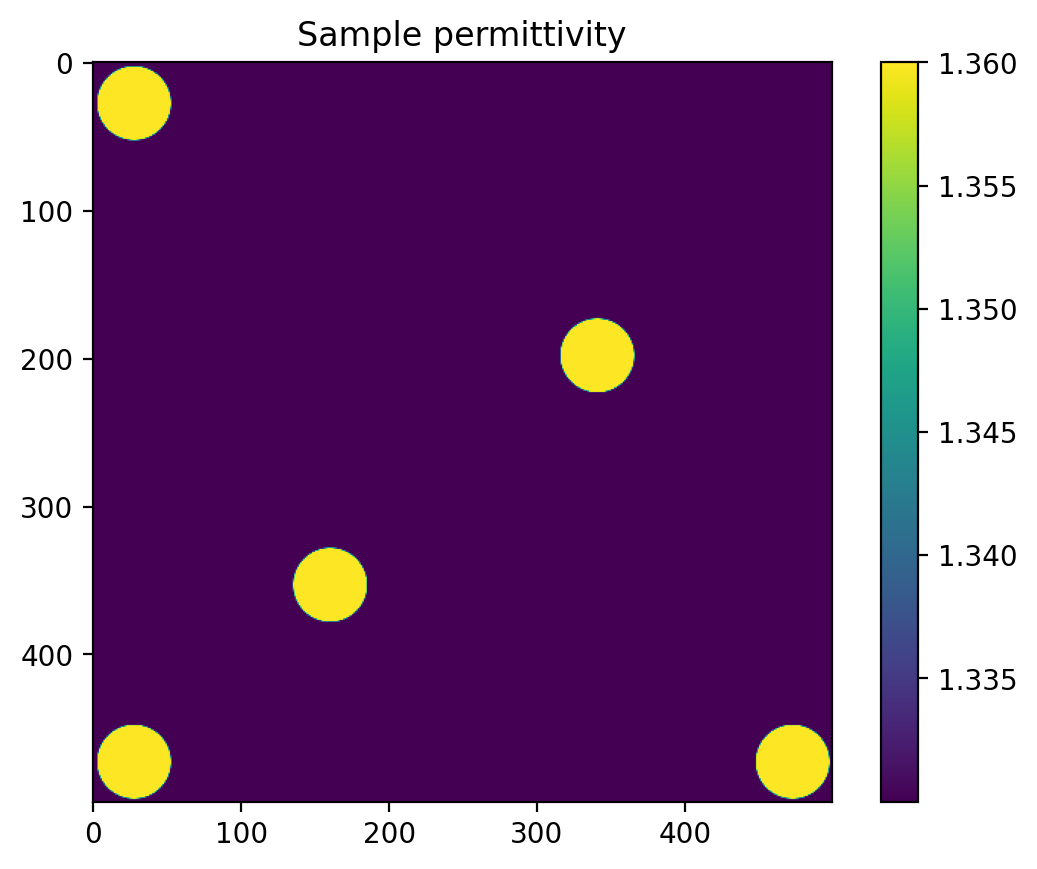

In [4]:
# Getting the sample
n_sample = bio_cylinders()[::2, :, ::2] # let's do a little smaller

print(f"Shape of sample: {n_sample.shape}")

plt.title("Sample permittivity")
plt.imshow(n_sample[:, 0, :])
plt.colorbar()

In [5]:
# Boundary setting
n_pad = tuple(0 if width_i is None else int(width_i / spacing) for width_i in boundary_width)
roi = tuple(slice(n, n + size) for n, size in zip(n_pad, n_sample.shape))

# Padding permittivity to new size
padding = [(0, 0) for _ in range(n_sample.ndim)]
for idx, n in enumerate(n_pad):
    padding[idx] = (n, n)
permittivity = jnp.pad(n_sample**2, padding, mode="edge") # permittivity is padded

# Adding boundary
km = 2 * jnp.pi * jnp.sqrt(jnp.mean(permittivity)) * spacing / wavelength
alpha = boundary_strength * km**2 / (2 * km)

# Defining distance from sample
r = jnp.ones_like(permittivity).at[roi].set(0)
r = distance_transform_edt(r)

# Making boundary
ar = alpha * r
P = reduce(
    lambda P, n: P + (ar**n / factorial(n, exact=True)),
    range(boundary_order + 1),
    jnp.zeros_like(ar),
)

numerator = alpha**2 * (boundary_order - ar + 2 * 1j * km * r) * ar ** (boundary_order - 1)
denominator = P * factorial(boundary_order, exact=True)
boundary = 1 / km**2 * numerator / denominator

# Adding it to the permittivity
permittivity += boundary

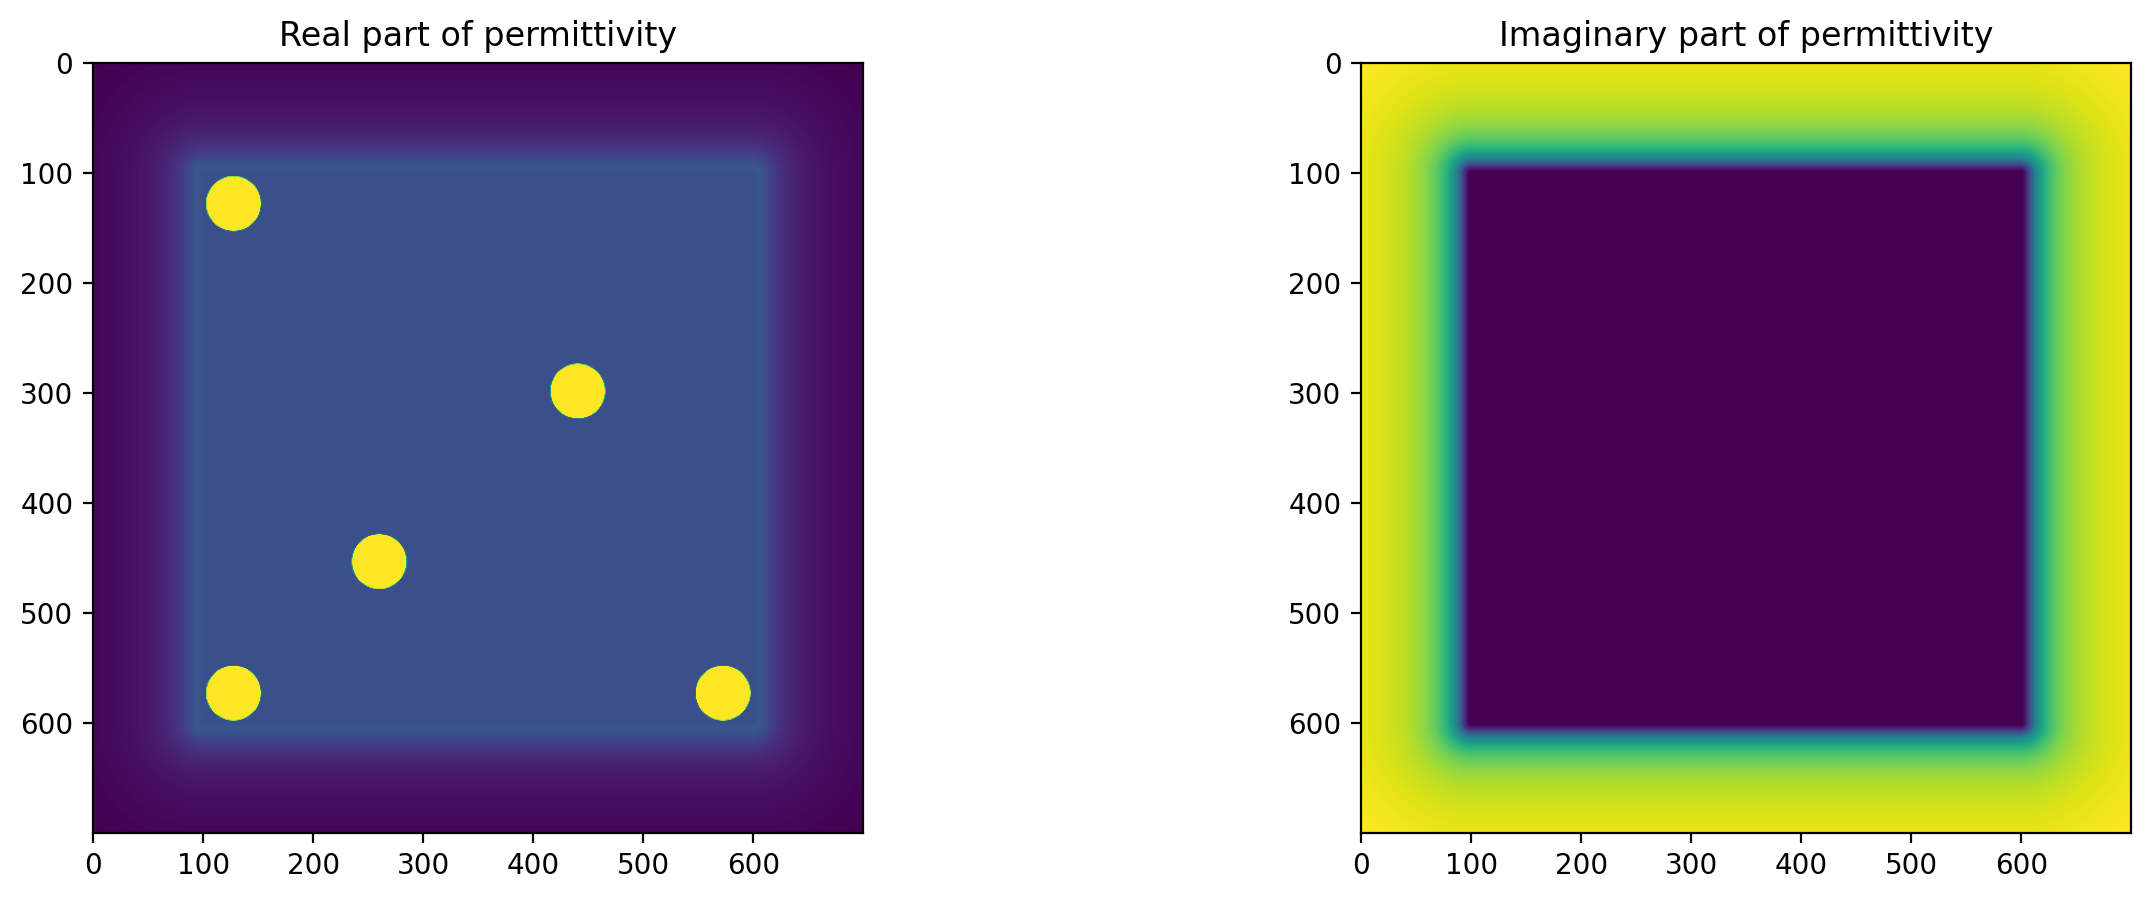

In [6]:
plt.figure(figsize=(15, 5))


plt.subplot(121)
plt.title("Real part of permittivity")
plt.imshow(jnp.real(permittivity[:, 0, :]))

plt.subplot(122)
plt.title("Imaginary part of permittivity")
plt.imshow(jnp.imag(permittivity[:, 0, :]))

plt.show()

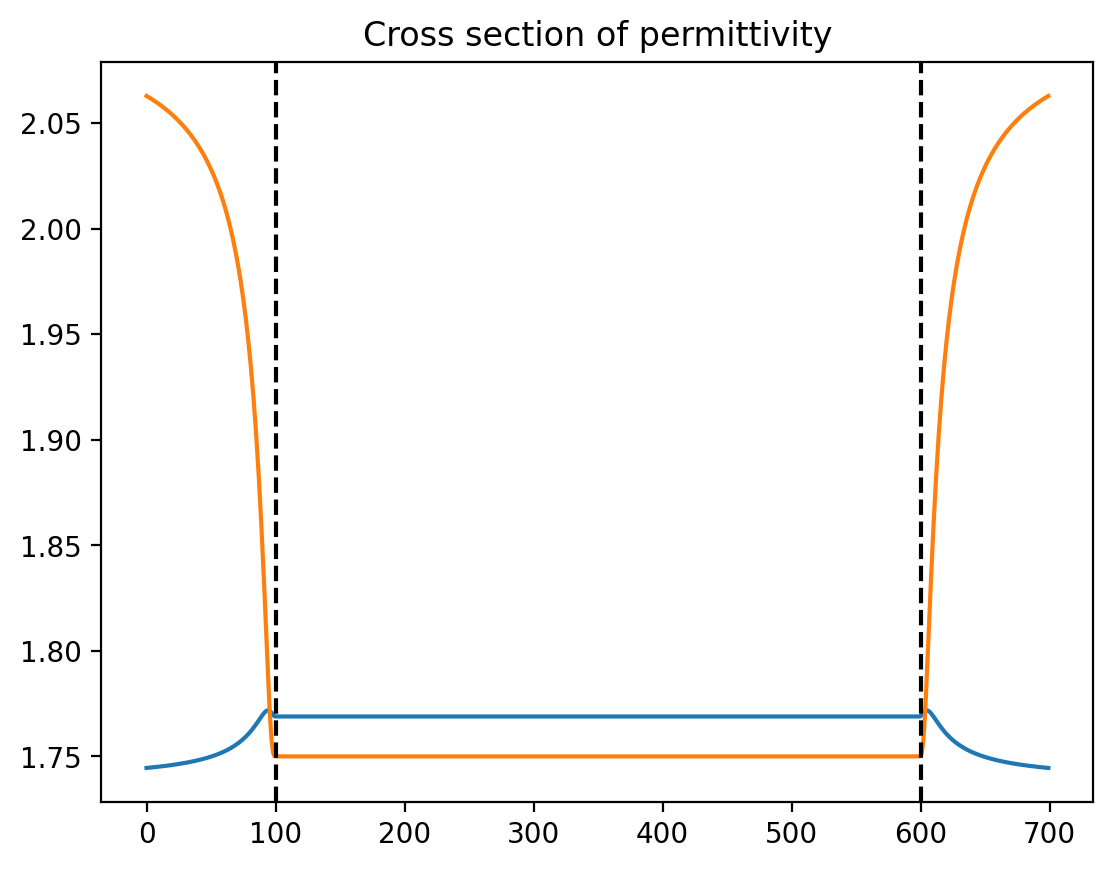

In [8]:
plt.title("Cross section of permittivity")
plt.plot(jnp.real(permittivity[500, 0]), label="Real")
plt.plot(jnp.imag(permittivity[500, 0]) + 1.75, label="Imaginary")

plt.axvline(100, color="k", linestyle="--")
plt.axvline(600, color="k", linestyle="--")
plt.show()

In [9]:
# Calculating optimal offset
alpha_real = (jnp.min(permittivity) + jnp.max(permittivity)) / 2
alpha_imag = jnp.max(jnp.abs(permittivity - alpha_real)) / 0.95
alpha = alpha_real + 1j * alpha_imag

print(f"Alpha set as {alpha:.2f}")

Alpha set as 1.80+0.34j


In [22]:
permittivity.shape

(700, 1, 700)

In [50]:
# Figuring out the padded shapes
padded_shape = (2048, 1, 2048) # we don't need to double fourier boundaries
n_pad = jnp.array(padded_shape) - jnp.array(permittivity.shape)
padding = ((0, n_pad[0].item()), (0, n_pad[1].item()), (0, n_pad[2].item()), (0, 0))

print(padding)

((0, 1348), (0, 0), (0, 1348), (0, 0))


In [51]:
# Getting the k-grid and the Greens function
# NOTE: Still not sure why we don't conserve |k| = 2 pi / lambda
k0 = 2 * jnp.pi / wavelength
ks = [2 * jnp.pi * jnp.fft.fftfreq(shape, spacing) for shape in padded_shape]
k_grid = jnp.stack(jnp.meshgrid(*ks, indexing="ij"), axis=-1)

k_sq = jnp.sum(jnp.abs(k_grid) ** 2, axis=-1)[..., None, None]
k_cross = k_grid[..., :, None] * k_grid[..., None, :] / (alpha * k0**2)
G = (jnp.eye(3) - k_cross) / (k_sq - alpha * k0**2)

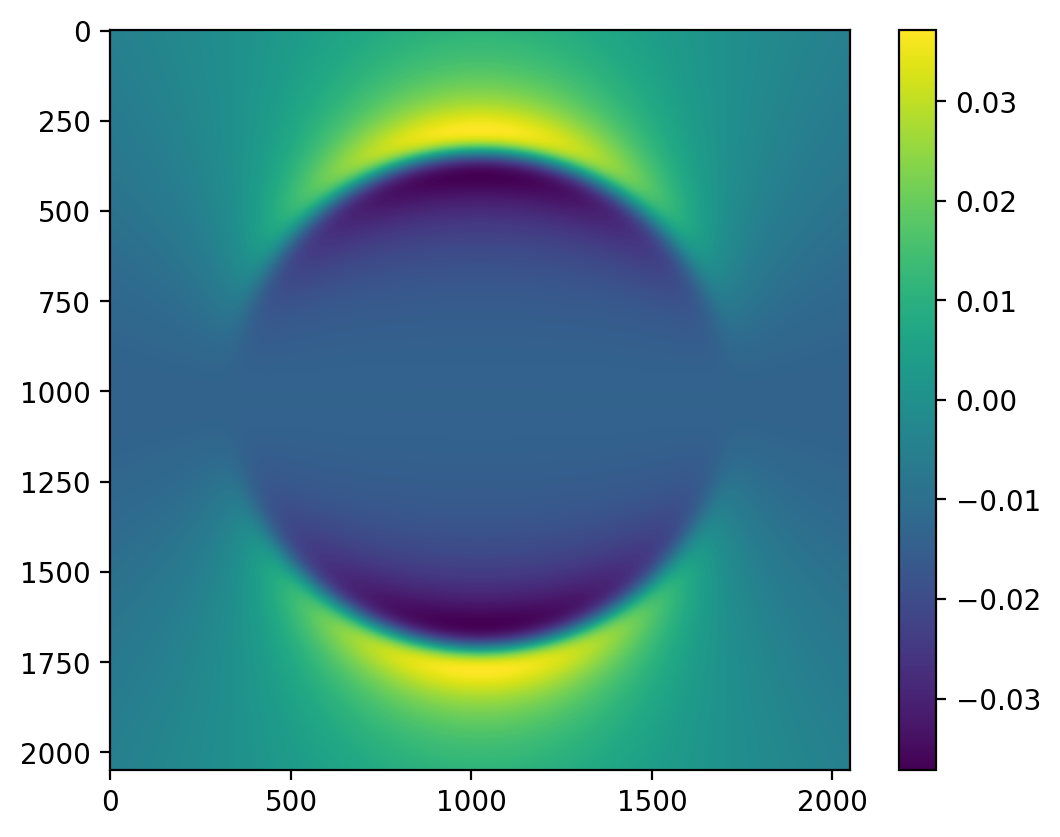

In [52]:
plt.imshow(jnp.fft.fftshift(G[:, 0, :, 2, 2].real))
plt.colorbar()

In [53]:
# Making the actual potential
V = (permittivity - alpha)[..., None]

# Setting up source
x_slice, y_slice, z_slice = roi
source = jnp.zeros((*permittivity.shape, 3)).at[x_slice, y_slice, z_slice, :].set((2 * jnp.pi / wavelength) ** 2 * jnp.array([0, 1, 1]))

In [54]:
source.shape

(700, 1, 700, 3)

In [55]:
# Doing the actual solving
def bmatvec(mat: Array, vec: Array) -> Array:
    return jnp.matmul(mat, vec[..., None]).squeeze(-1)

def propagate(G: Array, field: Array) -> Array:
    # This should be fixed - we're doing a circular convolution!
    fft = lambda x: jnp.fft.fftn(x, axes=(0, 1, 2))
    ifft = lambda x: jnp.fft.ifftn(x, axes=(0, 1, 2))

    return crop(ifft(bmatvec(G, fft(pad(field)))))

def update_fn(args):
    field, history, iteration = args

    # New field
    dE = 1j / alpha_imag * V * (propagate(G, k0**2 * V * field + source) - field)

    # Calculating change
    delta = jnp.mean(jnp.abs(dE) ** 2) / jnp.mean(jnp.abs(field) ** 2)

    return field + dE, history.at[iteration].set(delta), iteration + 1

def cond_fn(args) -> bool:
    _, history, iteration = args
    return (history[iteration - 1] > rtol) & (iteration < max_iter)

def pad(u):
    return jnp.pad(u, padding)

def crop(u):
    return u[:700, :, :700]

rtol =1e-8
max_iter = 500

init = update_fn((source, jnp.zeros(max_iter), 0))
field, history, iteration = jax.lax.while_loop(cond_fn, update_fn, init)
field_roi = field[roi], field

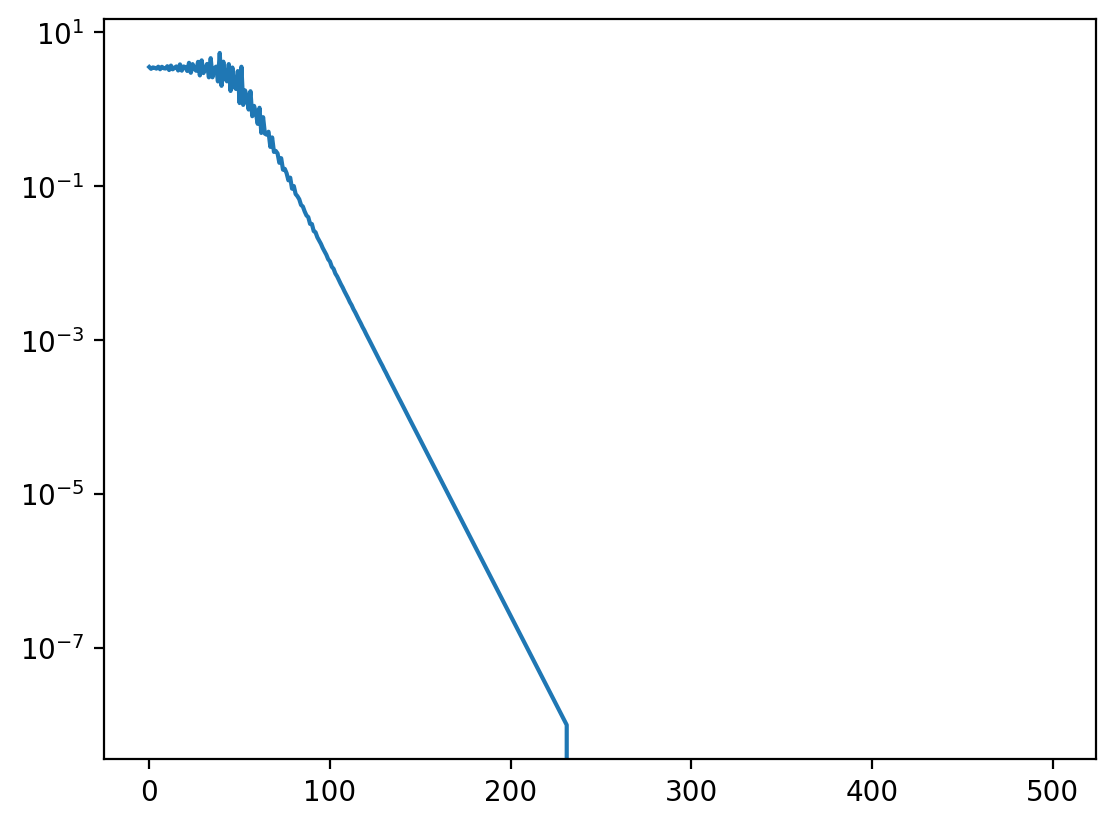

In [56]:
plt.semilogy(history)

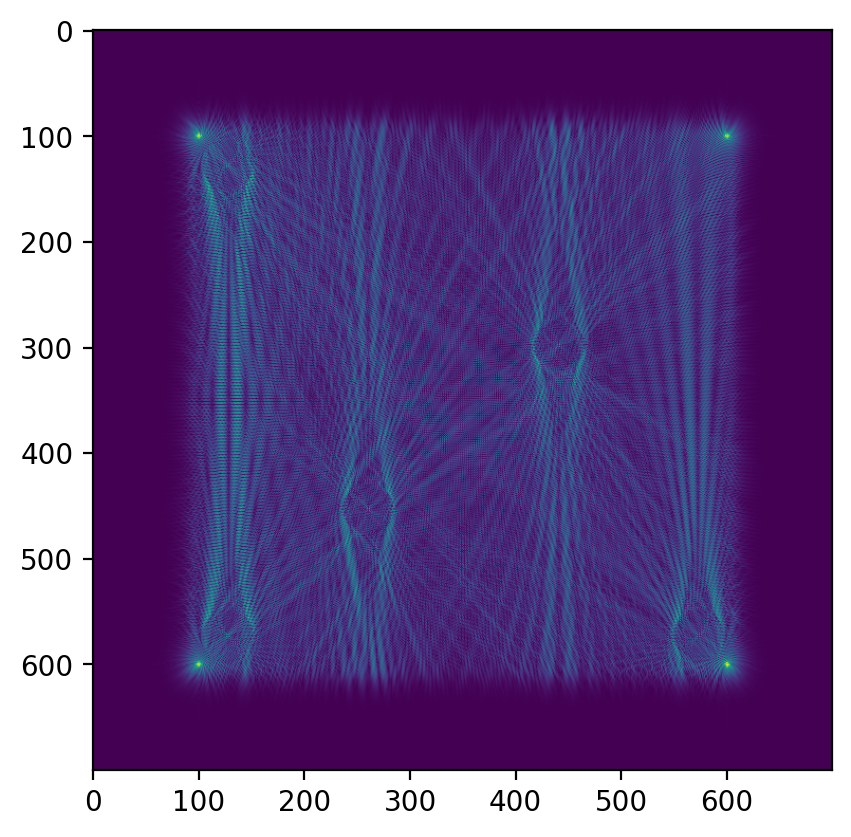

In [57]:
plt.imshow(jnp.abs(field[:, 0, :, 0]))

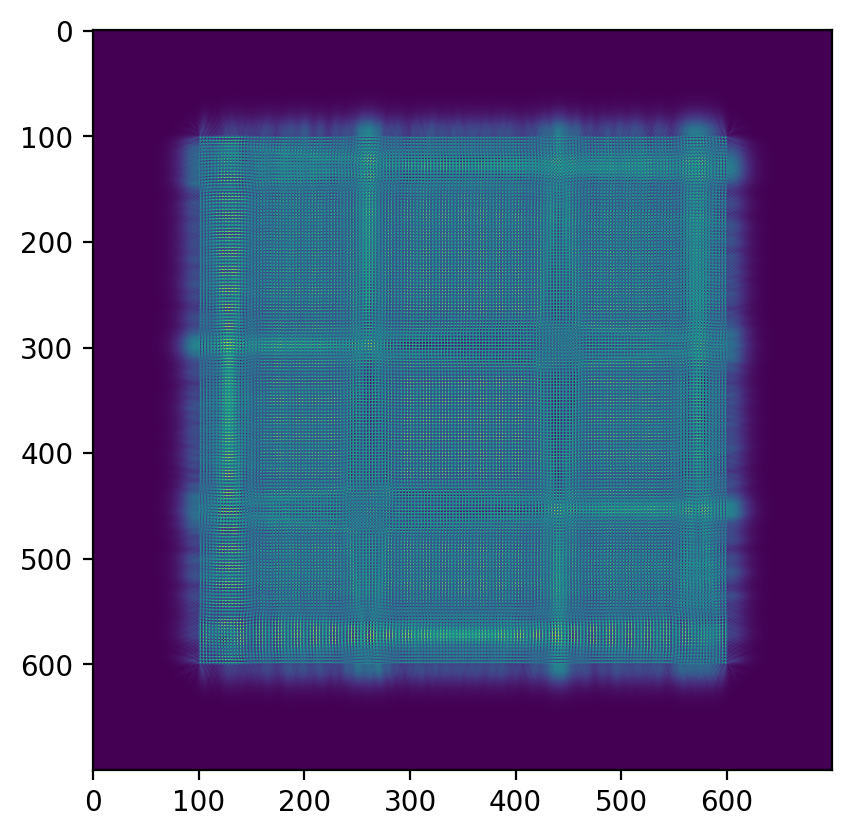

In [58]:
plt.imshow(jnp.abs(field[:, 0, :, 1]))

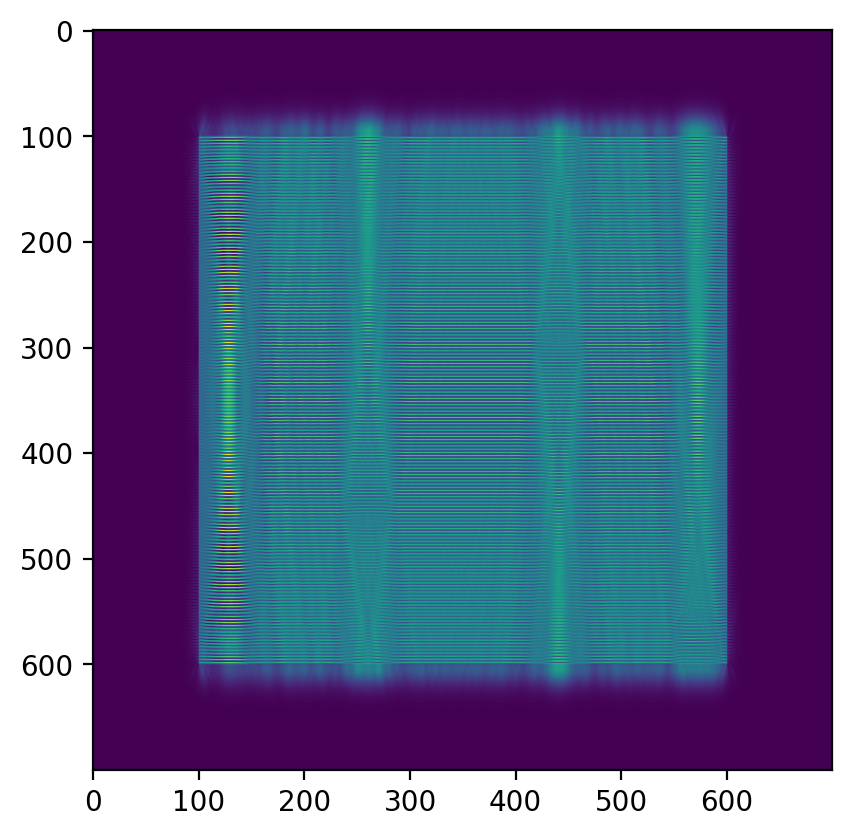

In [59]:
plt.imshow(jnp.abs(field[:, 0, :, 2]))